<a href="https://colab.research.google.com/github/hikmatfarhat-ndu/CSC645/blob/master/6zEmotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,Conv2D,Input,MaxPool2D,Dropout,Flatten,MaxPooling2D,BatchNormalization
from tensorflow.keras.models import Sequential


file=files.upload()
!mkdir /root/.kaggle
!mv kaggle.json  /root/.kaggle
!kaggle datasets download -d msambare/fer2013


Saving kaggle.json to kaggle.json
 81% 49.0M/60.3M [00:01<00:00, 41.8MB/s]
100% 60.3M/60.3M [00:01<00:00, 43.1MB/s]


In [2]:
!unzip fer2013.zip>/dev/null



### Retrieving the data as a Dataset Object

In [4]:
image_size=(48,48)
dataset=tf.keras.preprocessing.image_dataset_from_directory("train",batch_size=64,image_size=image_size,
                                                            shuffle=True,color_mode="grayscale")
test_dataset=tf.keras.preprocessing.image_dataset_from_directory("test",batch_size=64,image_size=image_size,
                                                            shuffle=False,color_mode="grayscale")

Found 28709 files belonging to 7 classes.


In [5]:
dataset.class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [6]:
it=iter(dataset)


In [7]:
item=it.next()
type(item)

tuple

In [8]:
print(item[0].shape,item[1].shape)

(64, 48, 48, 1) (64,)


tf.Tensor(
[2 0 3 3 0 0 3 3 4 5 4 4 0 5 6 0 3 4 3 5 6 6 3 3 2 0 2 2 4 3 6 6 4 4 3 5 5
 3 4 5 4 0 5 4 6 2 0 2 3 0 5 3 3 0 2 3 4 3 6 0 2 5 3 5], shape=(64,), dtype=int32)


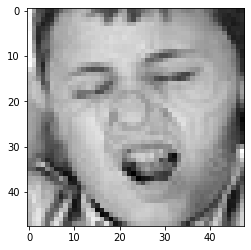

In [9]:
img=item[0][0]/255.
img=np.squeeze(img)
plt.imshow(img,cmap="gray")
print(item[1])

## Building the model

In [27]:
model = Sequential()
model.add(Input(shape=(image_size[0],image_size[1],1)))
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(.5))
    
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(.5))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation = 'softmax', name = 'Output'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 18, 18, 256)      

### Add optimizer, loss and metrics

In [11]:
model.compile(optimizer="Adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])

In [13]:
try:
  model.load_weights("emotions_weights.h5")
except:
  pass

## Run optimizer

In [15]:
model.fit(dataset,validation_data=test_dataset,epochs=20)

Epoch 1/20
449/449 [==============================] - 20s 45ms/step - loss: 1.5065 - accuracy: 0.4148 - val_loss: 1.3644 - val_accuracy: 0.4694
Epoch 2/20
449/449 [==============================] - 20s 45ms/step - loss: 1.3550 - accuracy: 0.4769 - val_loss: 1.2607 - val_accuracy: 0.5116
Epoch 3/20
449/449 [==============================] - 20s 45ms/step - loss: 1.2665 - accuracy: 0.5125 - val_loss: 1.1975 - val_accuracy: 0.5394
Epoch 4/20
449/449 [==============================] - 20s 45ms/step - loss: 1.2132 - accuracy: 0.5393 - val_loss: 1.1766 - val_accuracy: 0.5532
Epoch 5/20
449/449 [==============================] - 20s 45ms/step - loss: 1.1649 - accuracy: 0.5559 - val_loss: 1.1485 - val_accuracy: 0.5637
Epoch 6/20
449/449 [==============================] - 20s 45ms/step - loss: 1.1207 - accuracy: 0.5745 - val_loss: 1.1323 - val_accuracy: 0.5758
Epoch 7/20
449/449 [==============================] - 20s 45ms/step - loss: 1.0774 - accuracy: 0.5925 - val_loss: 1.1303 - val_accuracy:

Save the weights for later retrival and evaluate the model on the test data

In [16]:
model.save_weights("emotions_weights.h5")
model.evaluate(test_dataset)

113/113 [==============================] - 7s 58ms/step - loss: 1.1082 - accuracy: 0.6053


[1.108216643333435, 0.6053218245506287]

# Prediction Accuracy and Confusion Matrix

In [17]:
probabilities=model.predict(test_dataset)
predictions=np.argmax(probabilities,axis=1)
print(predictions[0:10])
predictions.shape

### Combine the "true" labels into an array

In [20]:
y = np.concatenate([y for x, y in test_dataset], axis=0)
y.shape

(7178,)

### Count the number of correct and wrong predictions

In [40]:

compare=y==predictions
unique,count=np.unique(compare,return_counts=True)
print(unique)
print(count)

[False  True]
[2833 4345]


### Confusion Matrix
The percentage of correct/wrong predictions doesn't tell the whole story. Some emotions are more correctly predicted than others. Towards that end we compute the confusion matrix

In [23]:
m=tf.math.confusion_matrix(y,predictions)
m

<tf.Tensor: shape=(7, 7), dtype=int32, numpy=
array([[ 530,    4,   66,   67,  103,  171,   17],
       [  29,   56,    5,    3,    4,   13,    1],
       [ 167,    5,  354,   50,  154,  216,   78],
       [  80,    0,   33, 1442,   94,   93,   32],
       [ 147,    3,   46,   99,  692,  240,    6],
       [ 172,    2,   95,   91,  205,  671,   11],
       [  44,    0,   64,   47,   40,   36,  600]], dtype=int32)>

In [38]:
totals=np.sum(m.numpy(),axis=1)

for i in range(7):
  print("{}={:.3f}".format(dataset.class_names[i],m[i,i].numpy()/totals[i]))

angry=0.553
disgust=0.505
fear=0.346
happy=0.813
neutral=0.561
sad=0.538
surprise=0.722


### Plotting the Confusion Matrix

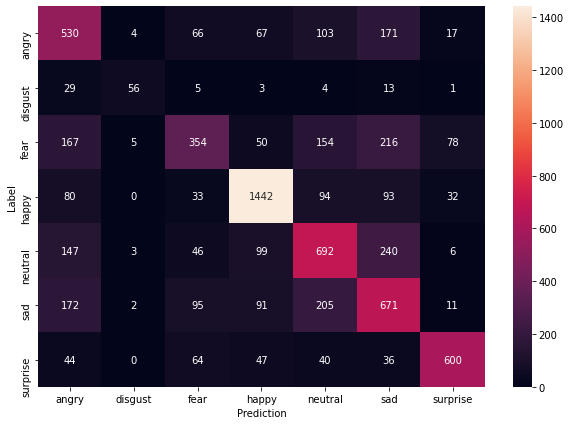

In [26]:
import seaborn as sns
plt.figure(figsize=(10, 7))
sns.heatmap(m, xticklabels=dataset.class_names, yticklabels=dataset.class_names, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

6
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


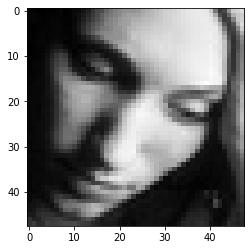

In [ ]:
idx=149
print(y[idx])
print(dataset.class_names)
plt.imshow(np.squeeze(x[idx]),cmap="gray")
